## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pickle
import os

# Histogram of explained variance
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

print(stimulus_train.shape)
print(spikes_train.shape)

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224
(2592, 3, 224, 224)
(2592, 168)


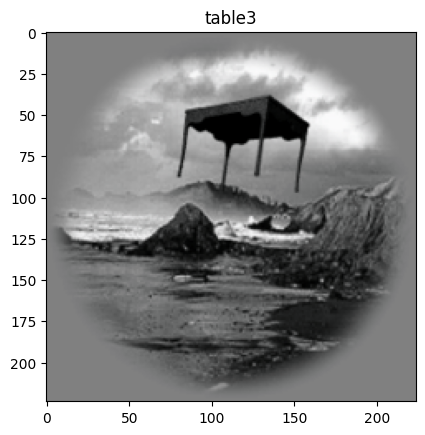

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

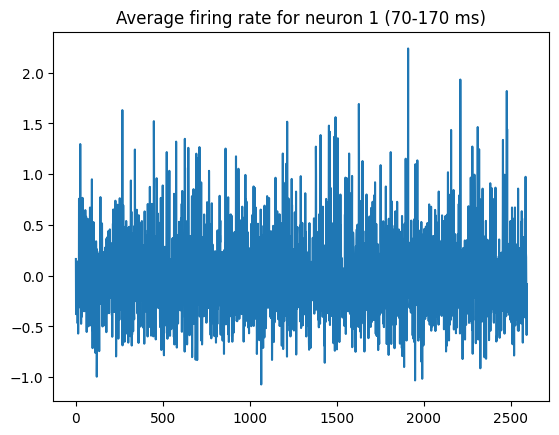

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

### Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
#### Reshape the input
stimulus_train_reshape = stimulus_train.reshape(n_stimulus, n_channels * img_size * img_size)
stimulus_val_reshape = stimulus_val.reshape(stimulus_val.shape[0], n_channels * img_size * img_size)
stimulus_test_reshape = stimulus_test.reshape(stimulus_test.shape[0], n_channels * img_size * img_size)

### Standardizxe with standard scaler
scaler = StandardScaler()
scaler.fit(stimulus_train_reshape)
stimulus_train_reshape = scaler.transform(stimulus_train_reshape)
stimulus_val_reshape = scaler.transform(stimulus_val_reshape)
stimulus_test_reshape = scaler.transform(stimulus_test_reshape)

In [8]:
# Linear regression on train
linear_regression = LinearRegression()

# Run if you want to train the model
#linear_regression.fit(stimulus_train_reshape, spikes_train)
#os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

# Run if you dont want to train the model
filename = 'NORMALIZED_simple_linear_non_reg.sav'
loaded_model = pickle.load(open(filename, 'rb'))
linear_regression = loaded_model

predictions_train = linear_regression.predict(stimulus_train_reshape)
predictions_val = linear_regression.predict(stimulus_val_reshape)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Linear regression on train
Train explained variance score: 1.0
Train r2 score: 1.0
Validation explained variance score: -0.9233438372612
Validation r2 score: -0.9318324327468872


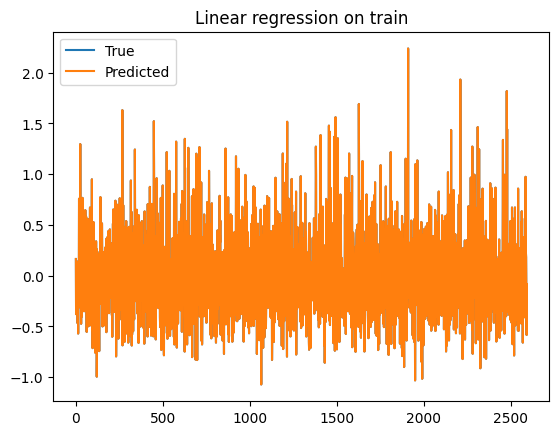

In [9]:
# Inspect
print('Linear regression on train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

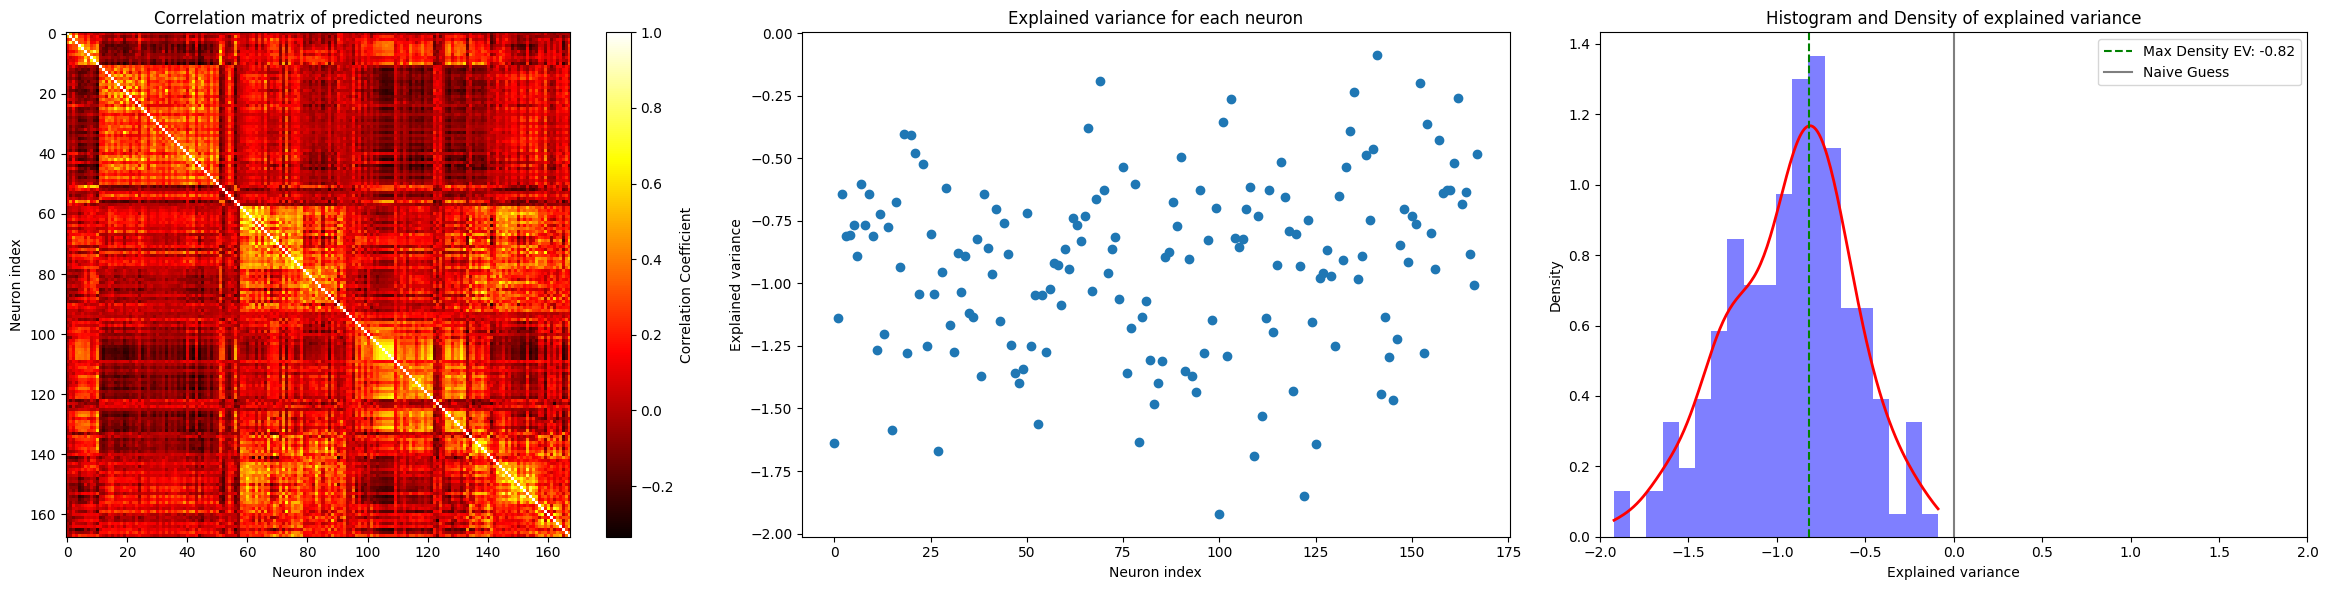

In [21]:
# Correlate the neurons of the model with each other and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_train.T)

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-2, 2)
axes[2].legend()

plt.tight_layout()
plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

In [12]:
# Apply PCA to the training data to reduce dimensionality of every image down to 1000 components
pca = PCA(n_components=1000)
pca.fit(stimulus_train_reshape)

# Transform the training, validation and test data
stimulus_train_pca = pca.transform(stimulus_train_reshape)
stimulus_val_pca = pca.transform(stimulus_val_reshape)
stimulus_test_pca = pca.transform(stimulus_test_reshape)

# Check the shape of the PCA transformed data
print(stimulus_train_pca.shape)
print(stimulus_val_pca.shape)

#os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

(2592, 1000)
(288, 1000)


In [ ]:
# Delete pre PCA data
'''
del stimulus_train_reshape
del stimulus_val_reshape
del stimulus_test_reshape
'''

In [14]:
# Apply normal linear regression to the PCA transformed data
linear_regression_pca = LinearRegression()
linear_regression_pca.fit(stimulus_train_pca, spikes_train)
predictions_train_pca = linear_regression_pca.predict(stimulus_train_pca)
predictions_val_pca = linear_regression_pca.predict(stimulus_val_pca)

Linear regression on PCA train
Train explained variance score: 0.46634945273399353
Train r2 score: 0.46634945273399353
Validation explained variance score: -0.07600448280572891
Validation r2 score: -0.07985483109951019


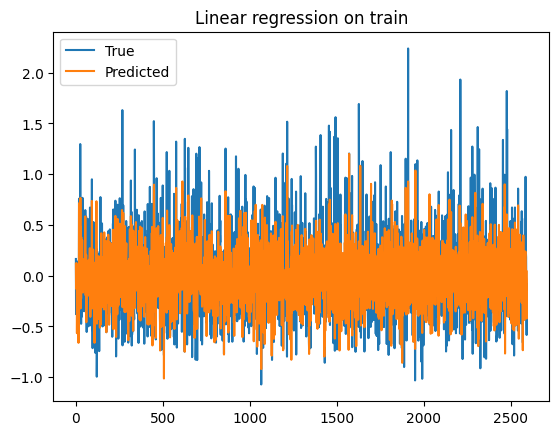

In [15]:
# Inspect
print('Linear regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_pca)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_pca)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_pca)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_pca)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train_pca[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

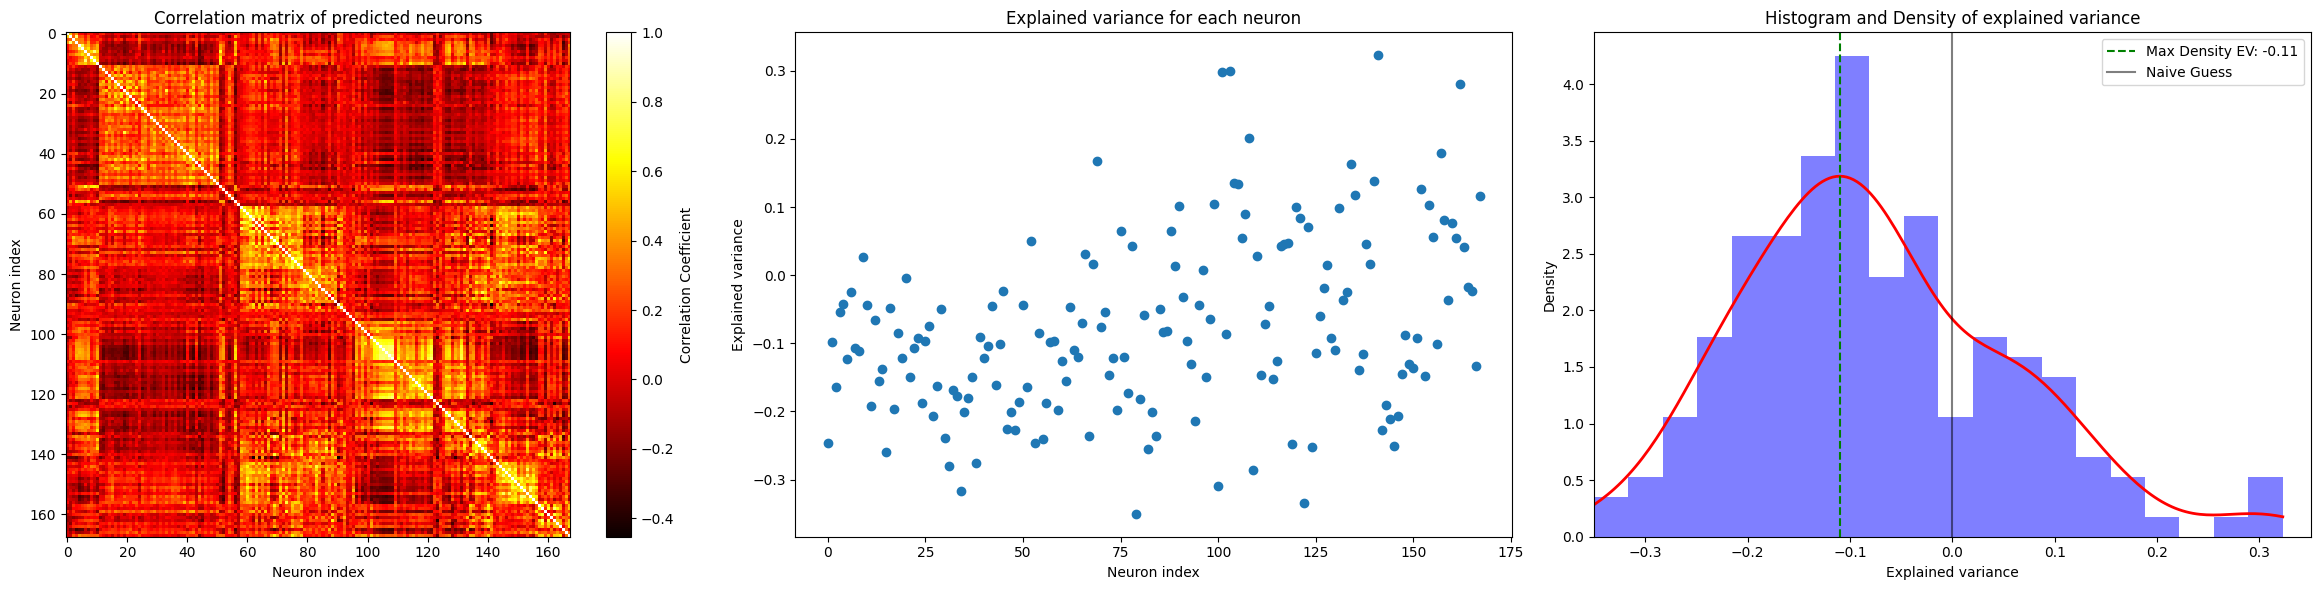

In [26]:
# Correlate the neurons of the model with each other and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_train_pca.T)

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_pca[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-most_extreme, most_extreme)
axes[2].legend()

plt.tight_layout()
plt.show()

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
# Perform ridge regression on the PCA transformed training data using cross-validation to find the best alpha value
ridge = Ridge()
alphas = np.linspace(0, 1e7, 200)
param_grid = {'alpha': alphas}

# Use explained variance as the scoring metric
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(stimulus_train_pca, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print('Best alpha value: {}'.format(best_alpha))

# Apply ridge regression with the best alpha value
ridge = Ridge(alpha=best_alpha)
ridge.fit(stimulus_train_pca, spikes_train)
predictions_train_ridge = ridge.predict(stimulus_train_pca)
predictions_val_ridge = ridge.predict(stimulus_val_pca)

os.system('afplay /System/Library/Sounds/Ping.aiff') # Notifies when the code is done

Best alpha value: 452261.3065326633


32512

Ridge regression on PCA train
Train explained variance score: 0.1767631322145462
Train r2 score: 0.1767631322145462
Validation explained variance score: 0.09146000444889069
Validation r2 score: 0.08736995607614517


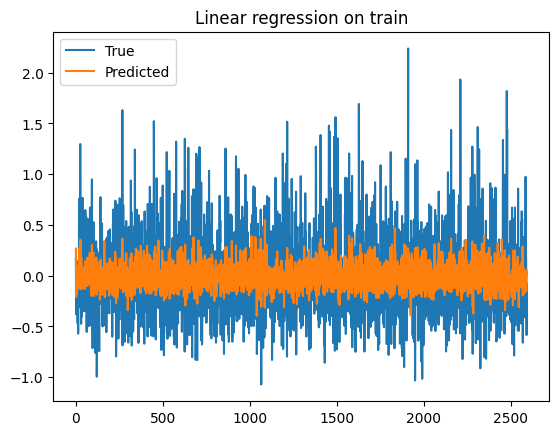

In [ ]:
# Inspect
print('Ridge regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_ridge)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_ridge)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_ridge)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_ridge)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train_ridge[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

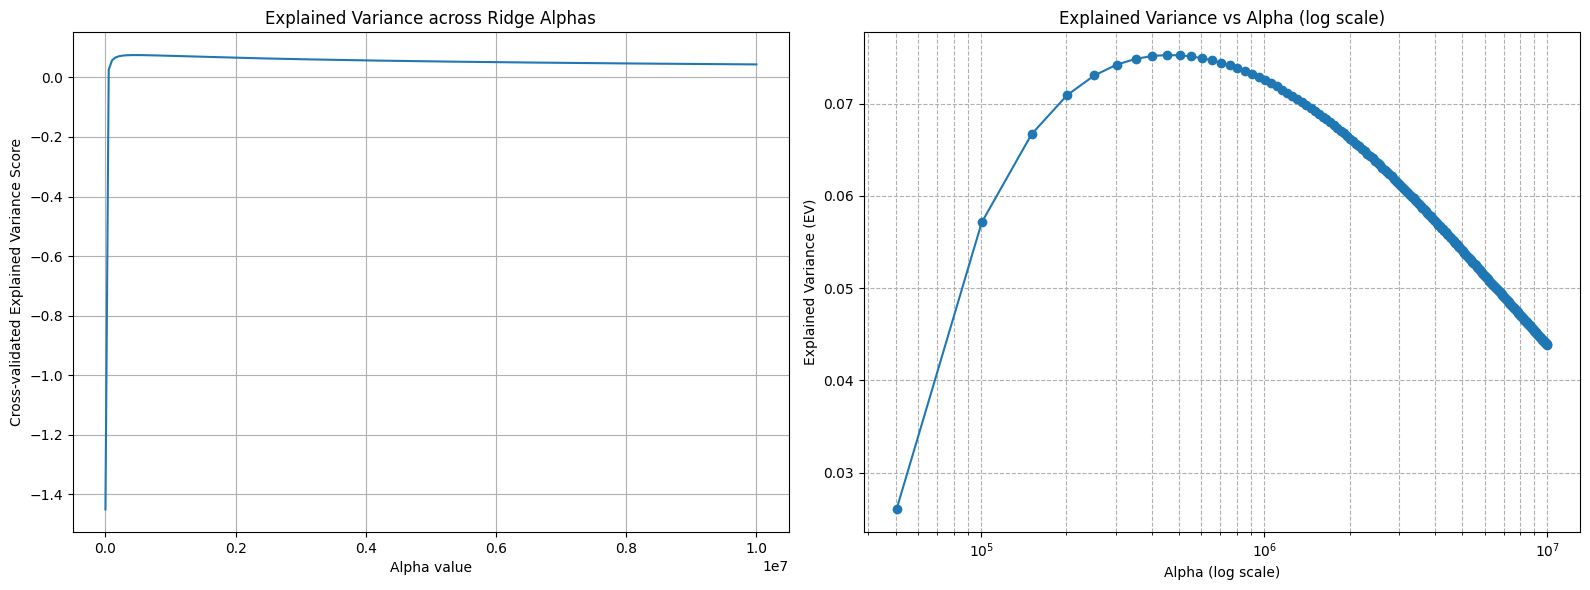

In [37]:
# plot the explained variance for each alpha value
mean_scores = grid_search.cv_results_['mean_test_score']

# Avoid log(0) by replacing alpha=0 with a very small number for plotting
alphas_for_plot = np.copy(alphas)
alphas_for_plot[alphas_for_plot == 0] = 1e-8  # tiny value instead of 0

# Plot both versions as subplots in a single figure
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: standard plot
ax[0].plot(alphas, mean_scores)
ax[0].set_xlabel('Alpha value')
ax[0].set_ylabel('Cross-validated Explained Variance Score')
ax[0].set_title('Explained Variance across Ridge Alphas')
ax[0].grid(True)

# Right subplot: semilogx plot
ax[1].semilogx(alphas_for_plot[1:], mean_scores[1:], marker='o')
ax[1].set_xlabel('Alpha (log scale)')
ax[1].set_ylabel('Explained Variance (EV)')
ax[1].set_title('Explained Variance vs Alpha (log scale)')
ax[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

# The EV improves until around 0 for higher alphas, but we lose significant performance on the training set wich proves that ridge won't help us to generalize better

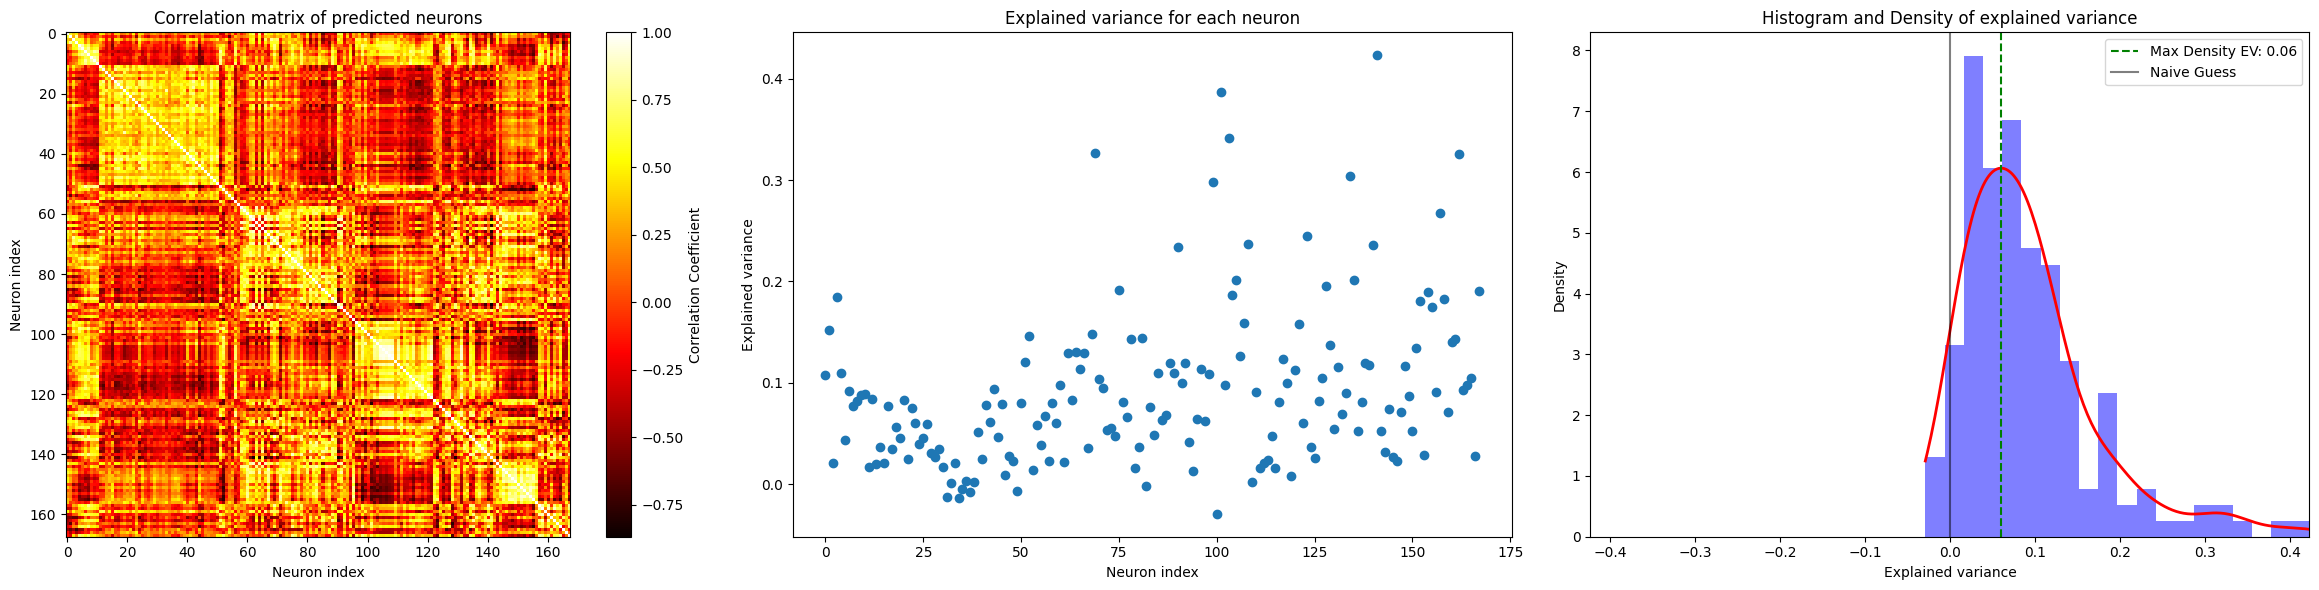

In [ ]:
# Correlate the neurons of the model with each other and plot the correlation matrix
correlation_matrix = np.corrcoef(predictions_train_ridge.T)

# Create the 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Correlation matrix ---
im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient')
axes[0].set_title('Correlation matrix of predicted neurons')
axes[0].set_xlabel('Neuron index')
axes[0].set_ylabel('Neuron index')

# --- Subplot 2: Explained variance scatter ---
ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
axes[1].scatter(range(n_neurons), ev_scores)
axes[1].set_xlabel('Neuron index')
axes[1].set_ylabel('Explained variance')
axes[1].set_title('Explained variance for each neuron')

# --- Subplot 3: Histogram + density of explained variance ---
axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
density = stats.gaussian_kde(ev_scores)
x = np.linspace(min(ev_scores), max(ev_scores), 200)
most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
axes[2].plot(x, density(x), 'r', linewidth=2)
max_density_val = x[np.argmax(density(x))]
axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
axes[2].set_xlabel('Explained variance')
axes[2].set_ylabel('Density')
axes[2].set_title('Histogram and Density of explained variance')
axes[2].set_xlim(-most_extreme, most_extreme)
axes[2].legend()

plt.tight_layout()
plt.show()

We can see that the explained variance improves as the alpha increases until alpha reaches 32.000. After that the perfomance starts to reduce as the model underfits. The best Ridge model achieves positive EV for almost every neuron, even though it does not get very high values.  This is actually expected, since individual pixels in an image do not necessitate being able to understand the entire image. Especially in IT neurons, which fire based on the actual image and require a holistic understanding of the image and context. Even when applying PCA, we are still effectively getting pieces of the image that represent the largest variance, rather than the object itself.

What might solve this is a task driven modeling approach, where we could model our network as the brain does at the level of the IT, rather than at a retinal level as is done above, with individual pixels being used for classification.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [7]:
import tensorflow as tf
import keras
import joblib
import gc

from keras.applications import ResNet50
from keras.models import Model
from keras.applications.resnet50 import preprocess_input
from keras import backend as K
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

K.clear_session()
gpus = tf.config.list_physical_devices('GPU')
print("Number of GPUs:", len(gpus))
print("GPUs:", gpus)

2025-04-26 19:48:39.583524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 19:48:39.604854: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 19:48:39.720990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 19:48:39.788876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745689719.906681 2646917 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745689719.93

Number of GPUs: 0
GPUs: []


2025-04-26 19:48:43.752552: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
# Get a pretrained resnet50 model
# - Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']

# Load model
pre_trained_model = ResNet50(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))

# Simplifies the layer names
layer_map = {
    'conv1': 'conv1_conv',
    'layer1': 'conv2_block3_out',
    'layer2': 'conv3_block4_out',
    'layer3': 'conv4_block6_out',
    'layer4': 'conv5_block3_out',
    'avgpool': 'avg_pool'
}

In [9]:
# Pixel value scalling and channel ordering
X_train_prep = preprocess_input(stimulus_train)
X_test_prep = preprocess_input(stimulus_val)

# Reshape the data to array strucutre
X_train_prep = np.reshape(X_train_prep, (X_train_prep.shape[0], img_size, img_size, n_channels))
X_test_prep = np.reshape(X_test_prep, (X_test_prep.shape[0], img_size, img_size, n_channels))

In [10]:
def inspect_alphas(grid_search, alphas, name):
    # plot the explained variance for each alpha value
    mean_scores = grid_search.cv_results_['mean_test_score']

    # Avoid log(0) by replacing alpha=0 with a very small number for plotting
    alphas_for_plot = np.copy(alphas)
    alphas_for_plot[alphas_for_plot == 0] = 1e-8  # tiny value instead of 0

    # Plot both versions as subplots in a single figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Left subplot: standard plot
    ax[0].plot(alphas, mean_scores)
    ax[0].set_xlabel('Alpha value')
    ax[0].set_ylabel('Cross-validated Explained Variance Score')
    ax[0].set_title('Explained Variance across Ridge Alphas')
    ax[0].grid(True)

    # Right subplot: semilogx plot
    ax[1].semilogx(alphas_for_plot[1:], mean_scores[1:], marker='o')
    ax[1].set_xlabel('Alpha (log scale)')
    ax[1].set_ylabel('Explained Variance (EV)')
    ax[1].set_title('Explained Variance vs Alpha (log scale)')
    ax[1].grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.savefig(f'alphas_analysis_{name}.png')
    plt.show()

In [11]:
def inspect_ridge(predictions_train_ridge, predictions_val_ridge, spikes_val, name):
    # Correlate the neurons of the model with each other and plot the correlation matrix
    correlation_matrix = np.corrcoef(predictions_train_ridge.T)

    # Create the 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # --- Subplot 1: Correlation matrix ---
    im = axes[0].imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Correlation Coefficient')
    axes[0].set_title('Correlation matrix of predicted neurons')
    axes[0].set_xlabel('Neuron index')
    axes[0].set_ylabel('Neuron index')

    # --- Subplot 2: Explained variance scatter ---
    ev_scores = [explained_variance_score(spikes_val[:, i], predictions_val_ridge[:, i]) for i in range(n_neurons)]
    axes[1].scatter(range(n_neurons), ev_scores)
    axes[1].set_xlabel('Neuron index')
    axes[1].set_ylabel('Explained variance')
    axes[1].set_title('Explained variance for each neuron')

    # --- Subplot 3: Histogram + density of explained variance ---
    axes[2].hist(ev_scores, bins=20, density=True, alpha=0.5, color='b')
    density = stats.gaussian_kde(ev_scores)
    x = np.linspace(min(ev_scores), max(ev_scores), 200)
    most_extreme = np.max(np.array([np.abs(np.min(ev_scores)), np.max(ev_scores)]))
    axes[2].plot(x, density(x), 'r', linewidth=2)
    max_density_val = x[np.argmax(density(x))]
    axes[2].axvline(x=max_density_val, color='g', linestyle='--', label=f'Max Density EV: {max_density_val:.2f}')
    axes[2].axvline(x=0, color='black', label="Naive Guess", alpha=0.5)
    axes[2].set_xlabel('Explained variance')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Histogram and Density of explained variance')
    axes[2].set_xlim(-most_extreme, most_extreme)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(f'ridge_regression_analysis_{name}.png')
    plt.show()

In [12]:
# Do PCA before hand and save it to file
for layer_name in layer_map.keys():

    print(f"Processing layer: {layer_name}")
    layer_index = list(layer_map.keys()).index(layer_name)
    activation_model = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer(layer_map[layer_name]).output)
    print(f"Model extracted")

    # 1. Extract test activations
    layer_train_acts = activation_model.predict(X_train_prep, batch_size=1)
    print(f"Extracted activations")

    del activation_model
    tf.keras.backend.clear_session()
    gc.collect()  # extra careful cleanup
    
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)
    print(f"Flattened activations")

    del layer_train_acts
    gc.collect()  # extra careful cleanup

    # Does PCA on the activations
    pca = PCA(n_components=1000)
    pca.fit(flat_train)
    print(f"Fitted PCA")

    # save pca model to pickle
    pca_filename = f'pca_model_{layer_name}.pkl'
    with open(pca_filename, 'wb') as f:
        pickle.dump(pca, f)
    print(f"Saved PCA model to {pca_filename}")

    del flat_train
    del pca
    gc.collect()  # extra careful cleanup
    print(f"Cleared memory\n")

Processing layer: conv1
Model extracted
 844/2592 ━━━━━━━━━━━━━━━━━━━━ 46s 26ms/step

: 

: 

: 

In [13]:
# loop over the rest of the layers
layer_pca_models = {}

for layer_name in layer_map.keys():

    print(f"Processing layer: {layer_name}")
    layer_index = list(layer_map.keys()).index(layer_name)

    activation_model = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer(layer_map[layer_name]).output)

    # 1. Extract test activations
    layer_test_acts = activation_model.predict(X_test_prep, batch_size=32)
    layer_train_acts = activation_model.predict(X_train_prep, batch_size=32)

    del activation_model
    tf.keras.backend.clear_session()
    gc.collect()  # extra careful cleanup
    
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)

    del layer_test_acts
    del layer_train_acts
    gc.collect()  # extra careful cleanup

    # Does PCA on the activations
    pca = PCA(n_components=1000)
    pca.fit(flat_train)
    # Transform the training, validation and test data
    test_pca = pca.transform(flat_test)
    train_pca = pca.transform(flat_train)
    
    # Delete the activations to save memory
    del flat_test
    del flat_train
    gc.collect()  # extra careful cleanup
    
    # Use explained variance as the scoring metric
    ridge = Ridge()
    alphas = np.linspace(1e4, 1e7, 50)
    param_grid = {'alpha': alphas}

    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='explained_variance')
    grid_search.fit(train_pca, spikes_train)

    best_alpha = grid_search.best_params_['alpha']
    print('Best alpha value: {}'.format(best_alpha))

    # Apply ridge regression with the best alpha value
    ridge.fit(stimulus_train_pca, spikes_train)
    predictions_train_ridge = ridge.predict(stimulus_train_pca)
    predictions_val_ridge = ridge.predict(stimulus_val_pca)

    # Inspect
    print('Ridge regression on PCA train')
    print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_ridge)))
    print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_ridge)))
    print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_ridge)))
    print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_ridge)))

    inspect_ridge(predictions_train_ridge, predictions_val_ridge, spikes_val, layer_name)
    inspect_alphas(grid_search, alphas, layer_name)

    print(f"{layer_name} → Explained Variance: {explained_variance_score(spikes_val, predictions_val_ridge):.4f}")

    # store the explained variance for each layer in a dictionary
    layer_pca_models[layer_name] = {
        'model': ridge,
        'explained_variance': explained_variance_score(spikes_val, predictions_val_ridge)
    }
    # Del PCA contents
    del pca
    del test_pca
    del train_pca

    # Del the activations
    del predictions_train_ridge
    del predictions_val_ridge

    # Del the model and grid search
    del ridge
    del grid_search
    gc.collect()  # extra careful cleanup

Processing layer: conv1
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


: 

: 

In [ ]:
# - Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?

In [ ]:
# - Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?


In [ ]:
# - Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?